In [51]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

import util

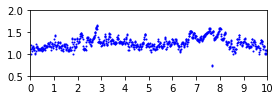

In [5]:
with open('../HR_data/a01.pkl', 'rb') as f:
    data = pickle.load(f)

plt.figure(figsize=(4,1.5))
plt.plot(data['t'], data['hr'], 'b.', markersize=2)
plt.xlim([0, 10])
plt.ylim([0.5, 2])
plt.xticks(np.arange(0, 11))
plt.tight_layout()
# plt.savefig('../archive/Data_HeartRate.png', dpi=300)

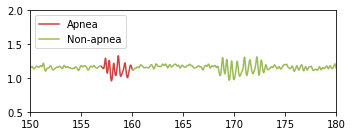

In [71]:
with open('../HR_data/b02.pkl', 'rb') as f:
    data = pickle.load(f)
t_hr, hr = util.smooth_hr(data['t'], data['hr'])
apn = data['apn']

minute_start, minute_end = [], []
minute_start.append(0)
for i in range(1, len(apn)):
    if apn[i] != apn[i-1]:
        minute_end.append(i)
        minute_start.append(i)

minute_end.append(len(apn) - 1)

plt.figure(figsize=(5,2))
plt.plot([-1, 0], [0, 0], '-', color=np.array([205, 65, 65]) / 255, label='Apnea')
plt.plot([-1, 0], [0, 0], '-', color=np.array([155, 187, 89]) / 255, label='Non-apnea')
for minute_start, minute_end in zip(minute_start, minute_end):
    if apn[minute_start] == 1:
        color = np.array([205, 65, 65]) / 255
    else:
        color = np.array([155, 187, 89]) / 255
    idx = (t_hr > minute_start) & (t_hr < minute_end)
    plt.plot(t_hr[idx], hr[idx], '-', markersize=2, color=color)
    
# plt.xlim([60, 90])
plt.xlim([150, 180])
plt.ylim([0.5, 2])
# plt.xticks(np.arange(0, 11))
plt.tight_layout()
plt.legend(loc='upper left')
# plt.savefig('../archive/Slide_HR_character.png', dpi=300)
plt.savefig('../archive/Slide_challenge.png', dpi=600)

In [21]:
file_all = pd.read_csv('../resources/File_all.csv')
pos, neg = [], [] 
for file in file_all['file']:
    with open(f'../HR_data/{file}.pkl', 'rb') as f:
        data = pickle.load(f)
        apn = data['apn']
        t = data['t']
        hr = data['hr']
    for minute in range(len(apn)):
        idx = (t > minute) & (t < minute + 1)
        temp = hr[idx]
        temp = temp - np.median(temp)
        if apn[minute]:
            pos += list(temp)
        else:
            neg += list(temp)

In [23]:
print(max(pos), min(pos), max(neg), min(neg))

98.91304347826087 -2.1665065508263375 98.95833333333333 -2.3634824326231128


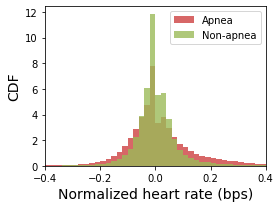

In [69]:
plt.figure(figsize=(4,3))
color_pos = np.array([205, 65, 65]) / 255
color_neg = np.array([155, 187, 89]) / 255
plt.hist(pos, bins=np.arange(-3, 3, 0.02), density=True, fc=(*color_pos, 0.8), label='Apnea')
plt.hist(neg, bins=np.arange(-3, 3, 0.02), density=True, fc=(*color_neg, 0.8), label='Non-apnea')
plt.xlim([-0.4, 0.4])
plt.xlabel('Normalized heart rate (bps)', size=14)
plt.ylabel('CDF', size=14)
plt.legend()
plt.tight_layout()
plt.savefig('../archive/Slide_time_feature.png', dpi=300)

In [53]:
psd_pos, psd_neg = [], []
freq = np.arange(0, 0.1, 0.001)
for file in file_all['file']:
    with open(f'../HR_data/{file}.pkl', 'rb') as f:
        res = pickle.load(f)
        hr = res['hr']
        t_hr = res['t'] # in minute
        apn = res['apn']
        
    t_hr, hr_smth = util.smooth_hr(t_hr, hr)

    # Resample data for frequency-domain analysis
    t_interp = np.arange(t_hr[0], t_hr[-1], 1 / 2.4 / 60)
    hr_interp = np.interp(t_interp, t_hr, hr_smth)

    # Extract features from each segment
    for minute in range(len(apn) - 4):
        hr_interp_5min = hr_interp[(t_interp > minute) & (t_interp < minute + 5)]

        # Frequency-domain features
        freq_, psd_ = signal.periodogram(hr_interp_5min, fs=2.4)
        psd = np.interp(freq, freq_, psd_)
        if apn[minute + 2]:
            psd_pos.append(psd)
        else:
            psd_neg.append(psd)


In [57]:
psd_pos = np.vstack(psd_pos)
psd_neg = np.vstack(psd_neg)

In [59]:
psd_pos.mean(axis=0).shape

(100,)

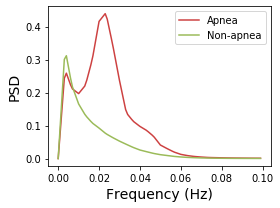

In [70]:
plt.figure(figsize=(4,3))
color_pos = np.array([205, 65, 65]) / 255
color_neg = np.array([155, 187, 89]) / 255
plt.plot(freq, psd_pos.mean(axis=0), '-', color=color_pos, label='Apnea')
plt.plot(freq, psd_neg.mean(axis=0), '-', color=color_neg, label='Non-apnea')
plt.xlabel('Frequency (Hz)', size=14)
plt.ylabel('PSD', size=14)
plt.legend()
plt.tight_layout()
plt.savefig('../archive/Slide_freq_feature.png', dpi=300)